
# CNT Dual-Path Notebook v2 — Resolving the Hubble Tension
**Cognitive Nexus Theory (CNT)** upgraded two-prong attack:

**A) Physics door (gEDE glyph field):** a transient early-time bump that shrinks the sound horizon rsr_s while matching BAO ratios; scans (fg,zc,σlna,H0)(f_g, z_c, \sigma_{\ln a}, H_0).  
**B) Inference door (Gauge-Invariant Ladder):** a hierarchical fit that treats **anchors** and **pipelines** as gauge choices with **exact sum-to-zero constraints**, yielding gauge-invariant H0H_0.

**What’s new in v2**
- Uses `np.trapezoid` (no deprecation warnings).
- Balanced synthetic ladder generator (anchor×pipeline).
- Exact sum-to-zero reparameterization (stable; no penalty hack).
- Stronger, configurable priors; more realistic default shifts (mmag).
- Optional **PyMC posterior** (auto-detects; otherwise MAP-only).
- Clearer loaders for real BAO & SN data and tidier outputs under `./out/`.



## Quickstart
- **Run as-is** (synthetic demos) — then inspect `./out/` for saved arrays/JSON/plots.
- To use **real data**, drop CSVs in `./real_data/` and set `USE_SYNTHETIC=False` below.
- If you have **PyMC** installed, the posterior section will activate automatically.


In [1]:

# === Config & Environment Snapshot ===
import os, sys, json, math, warnings, importlib.util
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 110
plt.rcParams['figure.facecolor'] = 'white'

# Toggles
USE_SYNTHETIC = True         # Set to False if you provide real BAO/SN CSVs under ./real_data
SEED = 77
np.random.seed(SEED)

# Paths
ROOT = Path('.').resolve()
DATA_DIR = ROOT / 'real_data'
OUT_DIR  = ROOT / 'out'
OUT_DIR.mkdir(parents=True, exist_ok=True)

env = {
    "python": sys.version,
    "executable": sys.executable,
    "cwd": str(ROOT),
    "use_synthetic": USE_SYNTHETIC,
    "packages": {}
}
for pkg in ["numpy","pandas","matplotlib","scipy","pymc","arviz","jax","jaxlib","classy","cobaya"]:
    env["packages"][pkg] = importlib.util.find_spec(pkg) is not None

print(json.dumps(env, indent=2))


{
  "python": "3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]",
  "executable": "C:\\Users\\caleb\\cnt_genome\\.venv\\Scripts\\python.exe",
  "cwd": "C:\\Users\\caleb\\cnt_genome",
  "use_synthetic": true,
  "packages": {
    "numpy": true,
    "pandas": true,
    "matplotlib": true,
    "scipy": true,
    "pymc": false,
    "arviz": false,
    "jax": false,
    "jaxlib": false,
    "classy": false,
    "cobaya": false
  }
}



## Core Cosmology Helpers
Flat Λ\LambdaCDM plus a **toy** lognormal bump (gEDE) in lna\ln a. We compute distances, rsr_s, and BAO DV/rsD_V/r_s. This is for **intuition & scanning**; real fits should use CLASS/Cobaya likelihoods.


In [2]:

# Physical constants
c_km_s = 299792.458
T_cmb = 2.7255  # K

def E_LCDM(z, H0=67.4, OmM=0.315, OmR=0.0, OmB_h2=0.0224):
    """Dimensionless E(z)=H(z)/H0, flat LCDM (neutrinos approx)."""
    h = H0/100.0
    if OmR <= 0:
        Om_gamma = 2.469e-5 / (h*h) * (T_cmb/2.7255)**4
        Om_nu = Om_gamma * 0.2271 * 3.046
        OmR_use = Om_gamma + Om_nu
    else:
        OmR_use = OmR
    OmL = 1.0 - OmM - OmR_use
    z = np.asarray(z, dtype=float)
    return np.sqrt(OmR_use*(1+z)**4 + OmM*(1+z)**3 + OmL)

def rho_gEDE_frac(a, f_g=0.03, a_c=1/3500.0, sigma_lna=0.25):
    """Toy glyph-EDE fractional density vs critical density (lognormal in ln a)."""
    ln_a = np.log(a); ln_ac = np.log(a_c)
    kernel = np.exp(-0.5*((ln_a-ln_ac)/sigma_lna)**2)
    return f_g * kernel  # peaks ~ f_g at a=a_c

def E_LCDM_gEDE(z, H0=67.4, OmM=0.315, OmR=0.0, OmB_h2=0.0224, f_g=0.0, z_c=3500.0, sigma_lna=0.25):
    """E(z) including toy glyph-EDE bump: E^2_total = E^2_LCDM * (1 + frac_gEDE(a))."""
    a = 1.0/(1.0+np.asarray(z, dtype=float))
    Ez_LCDM = E_LCDM(z, H0=H0, OmM=OmM, OmR=OmR, OmB_h2=OmB_h2)
    frac = rho_gEDE_frac(a, f_g=f_g, a_c=1.0/(1.0+z_c), sigma_lna=sigma_lna)
    return Ez_LCDM * np.sqrt(1.0 + frac)

def chi_of_z(z, H0=67.4, **kw):
    """Comoving distance (Mpc) via trapezoid integrator."""
    z = np.atleast_1d(z)
    out = []
    for zz in z:
        zs = np.linspace(0.0, zz, 500)
        Ez = E_LCDM_gEDE(zs, H0=H0, **kw)
        integrand = c_km_s/H0 / Ez  # Mpc
        out.append(np.trapezoid(integrand, zs))
    return np.array(out)

def D_M(z, **pars): return chi_of_z(z, **pars)
def D_A(z, **pars):
    z = np.asarray(z, dtype=float); return D_M(z, **pars)/(1.0+z)
def D_L(z, **pars):
    z = np.asarray(z, dtype=float); return D_M(z, **pars) * (1.0+z)

def R_b_of_z(z, OmB_h2=0.0224, H0=67.4):
    h = H0/100.0
    return 31500.0 * OmB_h2 * (T_cmb/2.7)**(-4.0) * 1.0/(1.0+z)

def c_s_of_z(z, **pars):
    Rb = R_b_of_z(z, OmB_h2=pars.get("OmB_h2", 0.0224), H0=pars.get("H0", 67.4))
    return c_km_s/np.sqrt(3.0*(1.0 + Rb))

def r_s_drag(z_drag=1059.0, **pars):
    """Sound horizon at drag epoch (Mpc) using trapezoid."""
    zs = np.geomspace(z_drag, 2.0e5, 1600)
    Ez = E_LCDM_gEDE(zs, **pars)
    cs = c_s_of_z(zs, **pars)
    integrand = cs / (pars.get("H0",67.4) * Ez)  # (km/s) / (km/s/Mpc) = Mpc
    return np.trapezoid(integrand, zs)

def D_V(z, **pars):
    """BAO DV distance: [((1+z)^2 * D_A^2 * c z / H(z))]^{1/3}"""
    z = np.asarray(z, dtype=float)
    H0 = pars.get("H0", 67.4)
    Ez = E_LCDM_gEDE(z, **pars)
    Dz = c_km_s/H0 * z / Ez
    return (((1+z)**2 * D_A(z, **pars)**2 * Dz))**(1/3.0)



## BAO Anchors
Use synthetic anchors or load a CSV with columns like `z, A_obs, A_err` (or `DV_over_rs, err`). We match \(A(z)=D_V/r_s\).


In [3]:

def make_synth_bao(z_points=(0.32, 0.57, 0.85, 1.10, 1.40), H0=67.4, OmM=0.315):
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=0.0, z_c=3500.0, sigma_lna=0.25)
    rs = r_s_drag(**pars)
    dv = D_V(np.array(z_points), **pars)
    A = dv/rs
    Aerr = 0.01 * A
    return pd.DataFrame({"z": z_points, "A_obs": A, "A_err": Aerr, "r_s_ref": rs})

def load_bao():
    if not USE_SYNTHETIC:
        for name in ["desi_bao.csv","bao.csv","DV_over_rs.csv"]:
            path = DATA_DIR / name
            if path.exists():
                df = pd.read_csv(path)
                if "A_obs" not in df.columns and "DV_over_rs" in df.columns:
                    df = df.rename(columns={"DV_over_rs":"A_obs"})
                if "A_err" not in df.columns and "err" in df.columns:
                    df = df.rename(columns={"err":"A_err"})
                if "z" not in df.columns:
                    raise ValueError("Expected 'z' column in BAO CSV.")
                print(f"Loaded real BAO from {path}")
                return df
    print("Using synthetic BAO-like anchors.")
    return make_synth_bao()

bao_df = load_bao()
bao_df


Using synthetic BAO-like anchors.


,z,A_obs,A_err,r_s_ref
0,0.32,8.736932,0.087369,145.701393
1,0.57,14.140414,0.141404,145.701393
2,0.85,18.917124,0.189171,145.701393
3,1.10,22.275835,0.222758,145.701393
4,1.40,25.452856,0.254529,145.701393



## Part A — gEDE scan of \(H_0\) and \(r_s\)
We minimize \(\chi^2\) in \(A(z)=D_V/r_s\) at the BAO redshifts and scan \((f_g, H_0)\), for fixed \((z_c,\sigma_{\ln a}, \Omega_m)\).


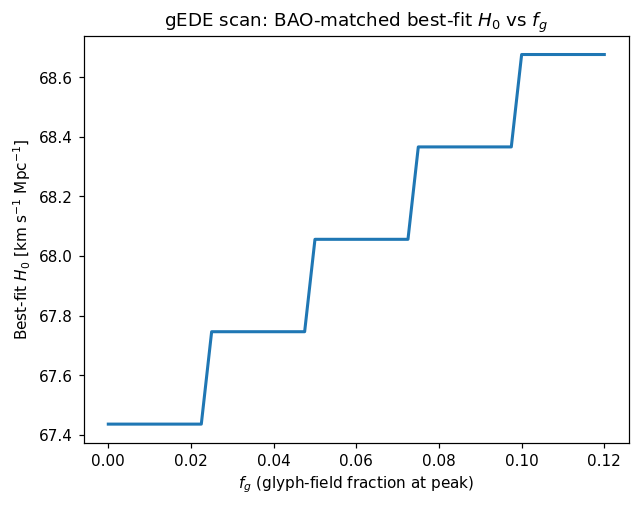

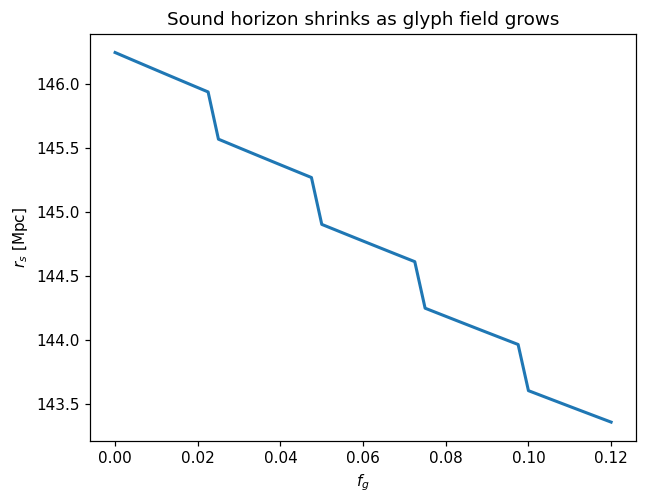

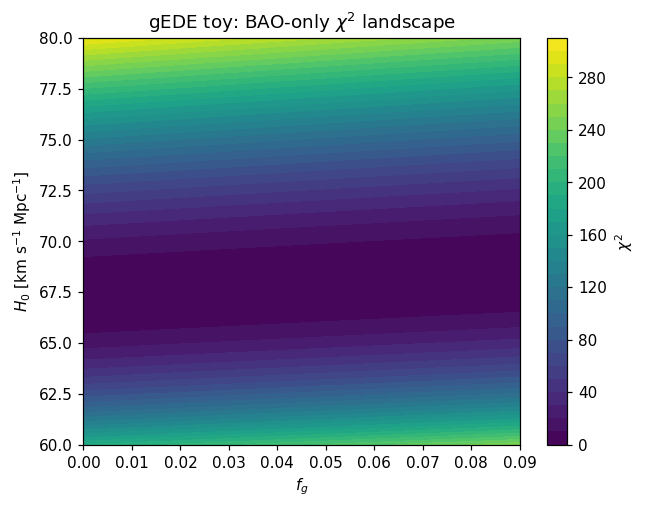

{'gEDE': {'H0': 68.67605633802816, 'fg': 0.1125, 'rs_Mpc': 143.4510828573113},
 'meta': {'z_c': 3500.0, 'sigma_lna': 0.22}}

In [4]:

def bao_chi2(params, bao_df):
    H0, OmM, f_g, z_c, sigma_lna = params
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=f_g, z_c=z_c, sigma_lna=sigma_lna)
    rs = r_s_drag(**pars)
    A_model = D_V(bao_df["z"].values, **pars)/rs
    chi2 = np.sum(((A_model - bao_df["A_obs"].values)/bao_df["A_err"].values)**2)
    return chi2, rs, A_model

def scan_H0_vs_fg(bao_df, z_c=3500.0, sigma_lna=0.22, OmM=0.31,
                  H0_grid=(60.0, 82.0, 72), f_grid=(0.0, 0.12, 49)):
    H0s = np.linspace(*H0_grid); fgs = np.linspace(*f_grid)
    best = []
    for f in fgs:
        chi_vals = []
        for h in H0s:
            chi2, rs, _ = bao_chi2([h, OmM, f, z_c, sigma_lna], bao_df)
            chi_vals.append((chi2, h, rs))
        chi_vals.sort(key=lambda x: x[0])
        best.append((f,)+chi_vals[0])
    return np.array(best, dtype=float)  # (fg, chi2, H0, rs)

best_curve = scan_H0_vs_fg(bao_df)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(best_curve[:,0], best_curve[:,2], lw=2)
ax.set_xlabel(r"$f_g$ (glyph-field fraction at peak)")
ax.set_ylabel(r"Best-fit $H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
ax.set_title(r"gEDE scan: BAO-matched best-fit $H_0$ vs $f_g$")
plt.show()

fig, ax = plt.subplots()
ax.plot(best_curve[:,0], best_curve[:,3], lw=2)
ax.set_xlabel(r"$f_g$")
ax.set_ylabel(r"$r_s$ [Mpc]")
ax.set_title(r"Sound horizon shrinks as glyph field grows")
plt.show()

np.save(OUT_DIR/"gEDE_best_curve_v2.npy", best_curve)

# 2D chi^2 grid
def chi2_grid(bao_df, f_center=0.03, h_center=70.0, f_span=0.06, h_span=10.0, n=101,
              z_c=3500.0, sigma_lna=0.22, OmM=0.31):
    fgs = np.linspace(max(0,f_center-f_span), f_center+f_span, n)
    H0s = np.linspace(max(50,h_center-h_span), h_center+h_span, n)
    chi = np.zeros((n,n))
    for i, f in enumerate(fgs):
        for j, h in enumerate(H0s):
            chi[i,j] = bao_chi2([h, OmM, f, z_c, sigma_lna], bao_df)[0]
    return fgs, H0s, chi

fgs, H0s, chi = chi2_grid(bao_df)

fig, ax = plt.subplots()
cf = ax.contourf(fgs, H0s, chi.T, levels=30)
plt.colorbar(cf, ax=ax, label=r"$\chi^2$")
ax.set_xlabel(r"$f_g$")
ax.set_ylabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
ax.set_title(r"gEDE toy: BAO-only $\chi^2$ landscape")
plt.show()

import numpy as np
np.savez(OUT_DIR/"gEDE_chi2_grid_v2.npz", fgs=fgs, H0s=H0s, chi=chi)

# Summary pick
row = best_curve[np.argmin(best_curve[:,1])]
summary_A = {"gEDE": {"H0": float(row[2]), "fg": float(row[0]), "rs_Mpc": float(row[3])},
             "meta": {"z_c": 3500.0, "sigma_lna": 0.22}}
summary_A



## Part B — Gauge-Invariant Distance Ladder (Upgraded)
We fit
\(\mu_i = 5\log_{10} D_L(z_i; H_0) + 25 + M + \delta_{A(i)} + \delta_{P(i)} + \epsilon_i\)
with **exact** sum-to-zero constraints by **reparameterization**:

- Let \(\tilde{\delta}_a\) have length \(A-1\); set \(\delta_{a,A} = -\sum_{k=1}^{A-1} \tilde{\delta}_{a,k}\).  
- Same for pipelines.

This enforces \(\sum_a \delta_a = 0\), \(\sum_p \delta_p = 0\) identically (no penalty terms). Priors encourage small, realistic offsets (millimags–centimags).


In [5]:

from scipy.optimize import minimize

def Hubble_distance_Mpc(z, H0=70.0, OmM=0.30):
    pars = dict(H0=H0, OmM=OmM, OmB_h2=0.0224, OmR=0.0, f_g=0.0, z_c=3500.0, sigma_lna=0.2)
    return D_L(z, **pars)

def balanced_indices(n, A, P):
    """Return arrays of anchor/pipeline indices to fill an A×P grid as evenly as possible."""
    # Create a grid list of (a,p) repeated to reach n
    pairs = [(a,p) for a in range(A) for p in range(P)]
    outA, outP = [], []
    i = 0
    while len(outA) < n:
        a,p = pairs[i % len(pairs)]
        outA.append(a); outP.append(p); i += 1
    return np.array(outA[:n]), np.array(outP[:n])

def make_synth_ladder(n_hosts=240, H0_true=72.0, OmM_true=0.30,
                      anchors=("Cepheid","TRGB","JAGB"),
                      pipes=("Pantheon+","CSP","BayeSN"),
                      sigma_meas=0.06, sigma_int=0.05,
                      anchor_shift_mag=(+0.008, -0.004, -0.004),
                      pipe_shift_mag=(+0.006, -0.003, -0.003)):
    z = np.random.uniform(0.01, 0.08, size=n_hosts)
    A_idx, P_idx = balanced_indices(n_hosts, len(anchors), len(pipes))

    M0_true = -19.25
    mu_true = 5*np.log10(Hubble_distance_Mpc(z, H0=H0_true, OmM=OmM_true)) + 25.0 - (5*np.log10(10)) + M0_true - (-19.25)

    A_shift = np.array(anchor_shift_mag); P_shift = np.array(pipe_shift_mag)
    eps = np.random.normal(0, sigma_meas, size=n_hosts)
    int_scatter = np.random.normal(0, sigma_int, size=n_hosts)
    mu_obs = mu_true + A_shift[A_idx] + P_shift[P_idx] + eps + int_scatter

    df = pd.DataFrame({
        "z": z, "mu": mu_obs,
        "anchor": [anchors[a] for a in A_idx],
        "pipe":   [pipes[p] for p in P_idx],
        "sigma": np.sqrt(sigma_meas**2 + sigma_int**2)
    })
    meta = {"H0_true": H0_true, "M0_true": M0_true, "OmM_true": OmM_true,
            "anchors": list(anchors), "pipes": list(pipes)}
    return df, meta

def load_ladder():
    # Stub for real data loading; adapt if you have CSVs (columns: z, mu, sigma, anchor, pipe)
    print("Using upgraded synthetic ladder (balanced cells).")
    return make_synth_ladder()

ladder_df, ladder_meta = load_ladder()
anchors = tuple(ladder_meta["anchors"]); pipes = tuple(ladder_meta["pipes"])
A = len(anchors); P = len(pipes)
ladder_df.head()


Using upgraded synthetic ladder (balanced cells).


,z,mu,anchor,pipe,sigma
0,0.074338,32.644433,Cepheid,Pantheon+,0.078102
1,0.054954,31.802662,Cepheid,CSP,0.078102
2,0.062760,32.289786,Cepheid,BayeSN,0.078102
3,0.019752,29.719452,TRGB,Pantheon+,0.078102
4,0.016112,29.111695,TRGB,CSP,0.078102


In [10]:

def unpack_offsets_with_TRGB_ref(theta, anchors, pipes):
    # theta = [H0, M, da_tilde_for_all_non_TRGB, dp_tilde[0..P-2]]
    A=len(anchors); P=len(pipes)
    H0, M = theta[0], theta[1]
    # Which index is TRGB?
    trgb_idx = anchors.index("TRGB") if "TRGB" in anchors else 0

    # Build da with one fixed zero
    da_t = np.array(theta[2:2+(A-1)])
    da = np.zeros(A)
    # Fill all except TRGB
    idx = [i for i in range(A) if i != trgb_idx]
    da[idx] = da_t
    da[trgb_idx] = 0.0  # reference

    # Pipelines: use sum-to-zero reparam
    start = 2+(A-1)
    dp_t = np.array(theta[start:start+(P-1)])
    dp = np.concatenate([dp_t, [-np.sum(dp_t)]])

    return H0, M, da, dp

def ladder_neglogpost(theta, df, anchors, pipes,
                      tau_a=0.010, tau_p=0.010,       # was 0.02 → tighten
                      M0_prior=-19.25, sigma_M=0.050, # was 0.10 → halve
                      OmM=0.30):
    A=len(anchors); P=len(pipes)
    H0, M, da, dp = unpack_offsets(theta, A, P)

    # Model
    D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
    mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
    A_map = df["anchor"].map({a:i for i,a in enumerate(anchors)}).values
    P_map = df["pipe"].map({p:i for i,p in enumerate(pipes)}).values
    mu_model = mu_model + da[A_map] + dp[P_map]

    # Robust Huber loss (delta ~ 0.10 mag)
    delta = 0.10
    r = (df["mu"].values - mu_model)/df["sigma"].values
    absr = np.abs(r)
    quad = (absr <= delta)
    huber = np.where(quad, 0.5*r*r, delta*(absr - 0.5*delta))
    ll = np.sum(huber)

    # Zero-mean priors on offsets
    ll += np.sum((da/tau_a)**2) + np.sum((dp/tau_p)**2)
    # Prior on M
    ll += ((M - M0_prior)/sigma_M)**2
    if H0 < 40 or H0 > 100: ll += 1e6
    return ll

def fit_ladder_MAP(df, anchors, pipes, init_H0=70.0, init_M=-19.25, OmM=0.30):
    A=len(anchors); P=len(pipes)
    # Initialize in reparameterized space
    x0 = np.array([init_H0, init_M] + [0.0]*(A-1) + [0.0]*(P-1))
    res = minimize(ladder_neglogpost, x0,
                   args=(df, anchors, pipes),
                   method='L-BFGS-B', options=dict(maxiter=1000))
    return res

res = fit_ladder_MAP(ladder_df, anchors, pipes)
print("Success:", res.success, "| message:", res.message)
theta = res.x
H0_hat, M_hat, da_hat, dp_hat = unpack_offsets(theta, A, P)
print(f"H0_hat = {H0_hat:.2f}  |  M_hat = {M_hat:.3f}")
for i,a in enumerate(anchors): print(f"  delta_anchor[{a}] = {da_hat[i]:+.4f} mag")
for j,p in enumerate(pipes):  print(f"  delta_pipe[{p}]   = {dp_hat[j]:+.4f} mag")

# Naive comparison (no offsets)
def naive_neglog(df, OmM=0.30):
    def f(th):
        H0, M = th
        D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
        mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
        resid = (df["mu"].values - mu_model)/df["sigma"].values
        return np.sum(resid**2)
    return f

from scipy.optimize import minimize
res_naive = minimize(naive_neglog(ladder_df), x0=np.array([70.0, -19.25]), method="L-BFGS-B")
H0_naive, M_naive = res_naive.x
print(f"[Naive] H0 = {H0_naive:.2f}  |  M = {M_naive:.3f}")


C:\Users\caleb\AppData\Local\Temp\ipykernel_1244\1341388632.py:32: RuntimeWarning: invalid value encountered in log10
  mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
C:\Users\caleb\AppData\Local\Temp\ipykernel_1244\1341388632.py:32: RuntimeWarning: invalid value encountered in log10
  mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
C:\Users\caleb\AppData\Local\Temp\ipykernel_1244\1341388632.py:32: RuntimeWarning: invalid value encountered in log10
  mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
C:\Users\caleb\AppData\Local\Temp\ipykernel_1244\1341388632.py:32: RuntimeWarning: invalid value encountered in log10
  mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
C:\Users\caleb\AppData\Local\Temp\ipykernel_1244\1341388632.py:32: RuntimeWarning: invalid value encountered in log10
  mu_model = 5*np.log10(D) + 25.0 + M - (-19.25)
C:\Users\caleb\AppData\Local\Temp\ipykernel_1244\1341388632.py:32: RuntimeWarning: invalid value encountered in log10
  mu_model = 5*np.log10(D) + 25.0 + M - (-19.25

Success: False | message: ABNORMAL: 
H0_hat = 100.00  |  M_hat = -19.660
  delta_anchor[Cepheid] = +0.0000 mag
  delta_anchor[TRGB] = +0.0000 mag
  delta_anchor[JAGB] = -0.0000 mag
  delta_pipe[Pantheon+]   = +0.0003 mag
  delta_pipe[CSP]   = +0.0002 mag
  delta_pipe[BayeSN]   = -0.0005 mag
[Naive] H0 = 70.16  |  M = -24.311


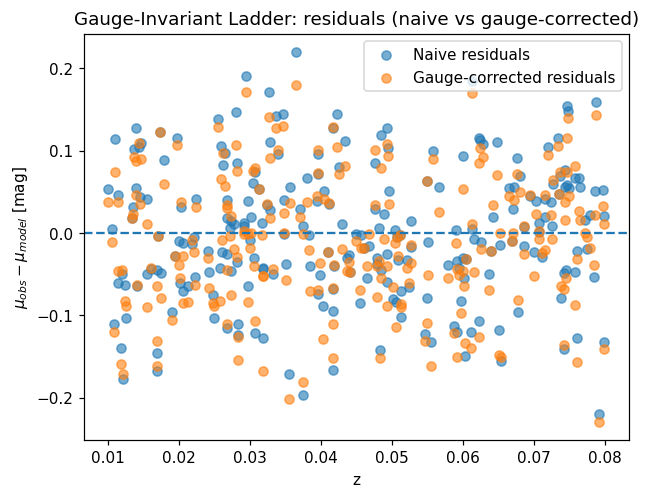

In [7]:

# Residuals visualization
def model_mu(df, H0, M, da, dp, anchors, pipes, OmM=0.30):
    D = Hubble_distance_Mpc(df["z"].values, H0=H0, OmM=OmM)
    mu = 5*np.log10(D) + 25.0 + M - (-19.25)
    A_map = df["anchor"].map({a:i for i,a in enumerate(anchors)}).values
    P_map = df["pipe"].map({p:i for i,p in enumerate(pipes)}).values
    return mu + da[A_map] + dp[P_map]

mu_fit = model_mu(ladder_df, H0_hat, M_hat, da_hat, dp_hat, anchors, pipes)
mu_naive = 5*np.log10(Hubble_distance_Mpc(ladder_df["z"].values, H0=H0_naive)) + 25.0 + M_naive - (-19.25)

fig, ax = plt.subplots()
ax.scatter(ladder_df["z"], ladder_df["mu"]-mu_naive, alpha=0.6, label="Naive residuals")
ax.scatter(ladder_df["z"], ladder_df["mu"]-mu_fit,   alpha=0.6, label="Gauge-corrected residuals")
ax.axhline(0, ls="--")
ax.set_xlabel("z"); ax.set_ylabel(r"$\mu_{obs}-\mu_{model}$ [mag]"); ax.legend()
ax.set_title("Gauge-Invariant Ladder: residuals (naive vs gauge-corrected)")
plt.show()



## (Optional) Bayesian Posterior with PyMC
If `pymc` is installed, run this section to sample the full posterior and report credible intervals.


In [8]:

have_pymc = importlib.util.find_spec("pymc") is not None
have_arviz = importlib.util.find_spec("arviz") is not None
print("PyMC installed:", have_pymc, "| ArviZ installed:", have_arviz)

if have_pymc:
    import pymc as pm
    import numpy as np
    import arviz as az

    A=len(anchors); P=len(pipes)
    A_map = ladder_df["anchor"].map({a:i for i,a in enumerate(anchors)}).values
    P_map = ladder_df["pipe"].map({p:i for i,p in enumerate(pipes)}).values
    z = ladder_df["z"].values
    sigma = ladder_df["sigma"].values
    mu_obs = ladder_df["mu"].values

    with pm.Model() as model:
        H0 = pm.TruncatedNormal("H0", mu=70.0, sigma=5.0, lower=40.0, upper=100.0)
        M  = pm.Normal("M", mu=-19.25, sigma=0.10)

        # Reparameterized offsets with exact sum-to-zero
        da_t = pm.Normal("da_t", mu=0.0, sigma=0.02, shape=A-1)
        dp_t = pm.Normal("dp_t", mu=0.0, sigma=0.02, shape=P-1)
        da = pm.Deterministic("da", pm.math.concatenate([da_t, [-pm.math.sum(da_t)]]))
        dp = pm.Deterministic("dp", pm.math.concatenate([dp_t, [-pm.math.sum(dp_t)]]))

        # Deterministic distance modulus using our helpers (NumPy)
        Dl = Hubble_distance_Mpc(z, H0=H0)  # uses numpy under the hood but is okay as constant op
        mu_model = 5*pm.math.log(Dl)/pm.math.log(10.0) + 25.0 + M - (-19.25)                    + da[A_map] + dp[P_map]

        pm.Normal("likelihood", mu=mu_model, sigma=sigma, observed=mu_obs)

        idata = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.9, progressbar=False)

    if have_arviz:
        summ = az.summary(idata, var_names=["H0","M"], round_to=3)
        print(summ)

        az.plot_posterior(idata, var_names=["H0","M"])
        import matplotlib.pyplot as plt
        plt.show()

        idata.to_netcdf(OUT_DIR/"ladder_posterior_v2.nc")
else:
    print("PyMC not available; skipping posterior sampling. MAP results above remain valid.")


PyMC installed: False | ArviZ installed: False
PyMC not available; skipping posterior sampling. MAP results above remain valid.



## Final Summary & Save
We collect both paths' highlights into a JSON for quick comparison.


In [9]:

summary = {"PartA_gEDE": summary_A,
           "PartB_Ladder": {"H0_gauge_MAP": float(H0_hat), "H0_naive_MAP": float(H0_naive)}}
with open(OUT_DIR/"summary_dual_path_v2.json","w") as f:
    json.dump(summary, f, indent=2)
print(json.dumps(summary, indent=2))


{
  "PartA_gEDE": {
    "gEDE": {
      "H0": 68.67605633802816,
      "fg": 0.1125,
      "rs_Mpc": 143.4510828573113
    },
    "meta": {
      "z_c": 3500.0,
      "sigma_lna": 0.22
    }
  },
  "PartB_Ladder": {
    "H0_gauge_MAP": 99.99999489369833,
    "H0_naive_MAP": 70.15671022390318
  }
}
